# Putting it all together!

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import Sequential, load_model

In [2]:
# Data Acquisition
DATA = "../data/raw"
LETS = list("SINO")
NUM_LETS = len(LETS)
IMG_SIZE = 100

In [3]:
# Model
model_path = "../data/model"
model_name = "model"

In [4]:
# Removes side noise by cropping the image
def crop_image(image, ratio):
    h, w, *_ = image.shape
    cropped = image[int(h/ratio): int(h*(ratio-1)/ratio), int(w/ratio): int(w*(ratio-1)/ratio)] # [y:h,x:w]
    return cropped

In [5]:
# Turns a colored image into gray scale
def black_and_white(image, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((2,2))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return closing

In [6]:
# Analyzes and image and returns each contour separately in a list along with its X coordinate
def get_letters(image):
    
    to_analyze = [] # letters will be placed here separately 
    
    image_inv = (255-image) 
    
    plt.imshow(image_inv, cmap="gray")
    
    # Retrieving all countours in the image
    contours = cv2.findContours(image_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]
    print(f"Contours found: {len(contours)}")
    
    # Analyzing each found contour
    for contour in contours:
        
        # Removing noise. Analyze countours which area is greater than 2000
        if cv2.contourArea(contour) > 1000:
            
            # Getting each contour x and y position as well as its width and height
            x, y, w, h = cv2.boundingRect(contour)
            
            e = 5 # Additional pixels at each of the four sides.
            
            # Appending each individual letter (rectangle) into a list to perform further analysis
            roi = image[y-e: y+h+e, x-e: x+w+e]
            to_analyze.append([roi, x]) # [individual letter, X position]
            
            # Identifying each contour with a rectangle and its index
#             cv2.rectangle(image, (x-e,y-e), (x+w+e, y+h+e), (0, 0, 0), 2)
#             text_font = cv2.FONT_HERSHEY_SIMPLEX
#             cv2.putText(image, f"{contours.index(contour)}", (x+e, y-e-5), text_font, 1, (0, 0, 0), 2)

    print(f"Letters split: {len(to_analyze)}")
    return to_analyze

Contours found: 6
Letters split: 4


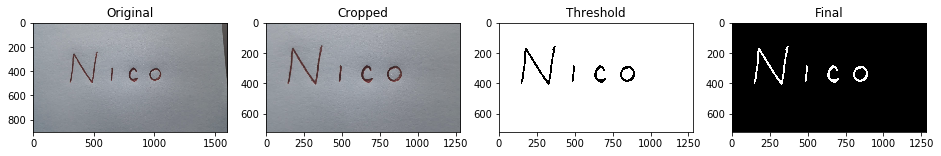

In [48]:
# Loading and preparing images, one by one
def split_image(img_path):
    
    # Exit the code if the image is not found
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found in path: {img_path}")
        #exit()
    
    cropped = crop_image(img, ratio=10)
    
    thresh = black_and_white(cropped, threshold=120)

    # Printing results using matplotlib
    thresh_inv = (255-thresh)
    images = [img, cropped, thresh, thresh_inv]
    titles = ["Original", "Cropped", "Threshold", "Final"]
    
    fig = plt.subplots(figsize=(16,10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
    
    letters = get_letters(thresh)
    
    #to_analyze = prep_letters(letters)
    
    #word = read_letters(to_analyze, model)
    
    return letters
    
#to_analyze = split_image("../data/playing/n.jpeg")
to_analyze = split_image("../data/test/n.jpeg")

(268, 241) area: 64588
(119, 30) area: 3570
(129, 88) area: 11352
(116, 110) area: 12760


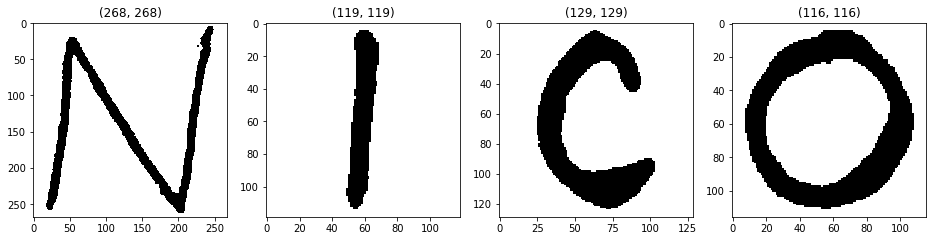

In [49]:
# analyzes each letter individualy.
def prep_letters(to_analyze):
    letters_predict = []
    # individual letter, X position. Sorting ascending by X value to_analyze[1]
    letters_sorted = sorted(to_analyze, key=lambda x: x[1])

    # Printing each letter
    fig = plt.subplots(figsize=(16,4))
    
    # Centering each letter into a square
    for i in range(len(letters_sorted)):
        
        letter = letters_sorted[i][0]
        h, w = letters_sorted[i][0].shape
        print(letters_sorted[i][0].shape, "area:", h*w)
        
        # Centering the letter into a perfect square, same height and width
        if h >= w:
            # if the image is taller than it is wide
            square_size = h
            extra_side_pixels = int((h - w)/2)
            
            frame = np.full((square_size, square_size), 255)
            frame[:, 0 + extra_side_pixels: w + extra_side_pixels] = letter
            
            letters_predict.append(frame)
            
        elif h < w:
            # if the image is wider than it is tall
            square_size = w
            extra_side_pixels = int((w - h)/2)
            frame = np.full((square_size, square_size), 255)
            frame[0 + extra_side_pixels: h + extra_side_pixels, :] = letter
            
            letters_predict.append(frame)
        
        plt.subplot(1, len(letters_sorted), i+1)
        plt.imshow(letters_predict[i], cmap="gray")
        plt.title(letters_predict[i].shape)

            # testing how area is calculated
#         plt.subplot(1, len(letters_sorted), i+1)
#         plt.imshow(letters_sorted[i][0], cmap="gray")
#         plt.title(letters_sorted[i][0].shape)

    plt.show();
    
    return letters_predict

to_predict = prep_letters(to_analyze)

In [9]:
model_path = "../data/model"
model_name = "model"
    
# loading the model
def load_model_h5(model_path, model_name):
    try:
        # Loading H5 file
        print(os.path.join(model_path, f"{model_name}.h5"))
        loaded_model = load_model(os.path.join(model_path, f"{model_name}.h5"))
        print("Model loaded successfully")
        return loaded_model
    except  Exception as e:
        print(os.path.join(model_path, f"{model_name}.h5"))
        print("Model couldn't be loaded. Did you import keras load_model function?")
        # exit()
        
loaded_model = load_model_h5(model_path, model_name)

../data/model/model.h5
Model loaded successfully


Letter predicted: N - Precision: 1.0
Letter predicted: S - Precision: 1.0
Letter predicted: I - Precision: 1.0
Letter predicted: O - Precision: 1.0
Letter predicted: S - Precision: 1.0
Letter predicted: N - Precision: 1.0

Your word is: NSIOSN


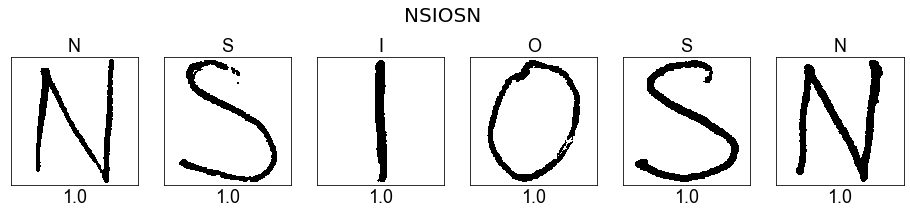

In [41]:
def read_letters(model, letters_to_predict, letters_list, pixels=100):
    """
    :param model: Model previously loaded into memory to predict image arrays.
    :param letters_to_predict: List of image arrays, sorted, each array represents a letter. 
    :param letters_list: Letters to analyze. Same list used before to load the images.
    :param pixels: Image width and height. Should be the same value used when loading the images. Default 100.
    :return: Word in a string object
    """
    word = []
    
    fig, axes = plt.subplots(1, len(letters_to_predict), figsize=(16,4))
    label_font = {"fontname" : "Arial", "fontsize": 18}
    
    # Analyzing each image array separately
    for index, img in enumerate(letters_to_predict):
        
        # Predicting each letter
        let = letters_to_predict[index].astype("float32") # array must be float32 for the resize function to work
        let = cv2.resize(let, (pixels, pixels))
        let = np.array(let).reshape(-1, pixels, pixels, 1)
        pred = model.predict(let)
        pred_index = np.argmax(pred)
        word.append(letters_list[pred_index])
        print(f"Letter predicted: {letters_list[pred_index]} - Precision: {pred[0][pred_index]}")
        
        # Printing each letter into a matplotlib axis
        axes[index].imshow(letters_to_predict[index], cmap="gray")
        axes[index].set_title(letters_list[pred_index], fontdict=label_font)
        axes[index].set_xlabel(pred[0][pred_index], fontdict=label_font)
        axes[index].set_xticks([])
        axes[index].set_yticks([])
        
    
    word = "".join(word)
    
    fig.suptitle(word, fontsize=20, y=0.9)
    plt.savefig(f"../data/prediction/{word}.png")
    return word

predicted_word = read_letters(loaded_model, to_predict, LETS, IMG_SIZE)
print(f"\nYour word is: {predicted_word}")